In [16]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# добыча данных
Итак, нам нужно 4 языка с похожими алфавитами. Я беру английский, нидерландский, африкаанс и индонезийский – у них иденичные алфавиты, поэтому разница будет только в нграммах.

(на самом деле не совсем идентичные, в африкаанс есть буквы с диакритиками, но они довольно редкие и выяснилось это довольно поздно)

In [1]:
import wikipedia

In [3]:
langs = ['en', 'af', 'nl', 'id']

artcls = {}

for lang in langs:
    wikipedia.set_lang(lang)
    pages = wikipedia.random(pages=200)
    contents = []
    for pg in pages:
        try:
            page = wikipedia.page(pg)
            contents.append(page.content)
        except:
            continue
    artcls[lang] = contents

/Users/user/myproject/venv/anaconda3/envs/maga/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/user/myproject/venv/anaconda3/envs/maga/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


In [5]:
for key in artcls:
    print('{}: {}'.format(key, len(artcls[key])))

id: 199
nl: 191
en: 188
af: 198


In [6]:
articles = pd.DataFrame({'lg': ['en']*len(artcls['en'])+['af']*len(artcls['af'])+['nl']*len(artcls['nl'])+['id']*len(artcls['id']),
                         'text': artcls['en']+artcls['af']+artcls['nl']+artcls['id']})

articles.head()

,lg,text
0,en,Ernest Franklin Zeigler II (born (1966-01-31)J...
1,en,The Al-Zubair 2 is a Sudanese main battle tank...
2,en,Language proficiency or linguistic proficiency...
3,en,Aggrey Zola Klaaste (6 January 1940 – 19 June ...
4,en,Central Fire Station is a historic fire statio...


In [15]:
articles.to_pickle('articles.pickle')

# препроцессинг

In [8]:
# вообще-то токенизатор векторайзера по умолчанию полностью игнорирует знаки препинания но это только если мы по словам смотрим
# поэтому удаляем все цифры знаки препинания вот это всё
def preproc(text):
    from string import punctuation
    text = re.sub('[{}0-9”]+'.format(punctuation), '', text)
    text = re.sub('\s+'.format(punctuation), ' ', text)
    text = text.lower()
    return text

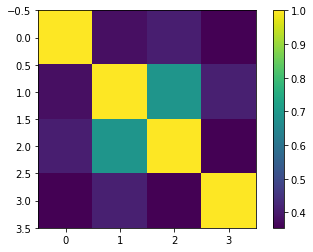

In [27]:
# несколько более интрепретируемой будет таблица схожести по языкам, а не по документам. 
# Для этого можно схлопнуть все документы одного языка в одну клетку таблицы

articloids = pd.DataFrame({'lg': langs,
                         'text': ['\n'.join(artcls['en']), '\n'.join(artcls['af']), 
                                  '\n'.join(artcls['nl']), '\n'.join(artcls['id'])]})

vect = TfidfVectorizer(ngram_range=(3,3), analyzer='char', preprocessor=preproc)
matr = vect.fit_transform(articloids['text'])

# таблица схожести

similarities = cosine_similarity(matr)


import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(similarities)
plt.colorbar()
plt.show()

Очевидно, что нидерландский и африкаанс очень похожи друг на друга (как и ожидалось), а ещё африкаанс немного больше похож на индонезийский, чем на английский, а нидерландский наоборот, но это может быть вообще незначимо.

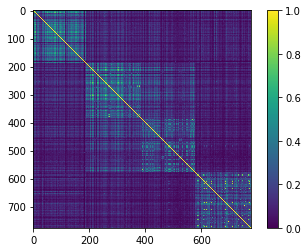

In [14]:
# можно, конечно, построить такую матрицу и для текстов

vect = TfidfVectorizer(ngram_range=(3,3), analyzer='char', preprocessor=preproc)
matr = vect.fit_transform(articles['text'])

similarities = cosine_similarity(matr)


import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(similarities)
plt.colorbar()
plt.show()

Получилось примерно то же самое. Интересно, что некоторые документы тёмными линиями не похожи вообще ни на что, кроме самих себя, даже внутри того же языка

# обучение

In [4]:
articles = pd.read_pickle('articles.pickle')

In [9]:
vect = TfidfVectorizer(ngram_range=(3,3), analyzer='char', preprocessor=preproc)
matr = vect.fit_transform(articles['text'])

X_train, X_test, y_train, y_test = train_test_split(matr, articles['lg'])

nb = MultinomialNB()
nb.fit(X_train, y_train)

In [13]:
langs = ['en', 'af', 'nl', 'id']
pred = nb.predict(X_test)
print(classification_report(y_test, pred, target_names=langs))
print(confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

         en       0.83      1.00      0.91        48
         af       1.00      1.00      1.00        48
         nl       1.00      1.00      1.00        49
         id       1.00      0.80      0.89        49

avg / total       0.96      0.95      0.95       194

[[48  0  0  0]
 [ 0 48  0  0]
 [ 0  0 49  0]
 [10  0  0 39]]


И ничего себе. Модель почему-то только приняла несколько индонезийских текстов за английские, а в остальном безошибочно угадывала языки.

Сейчас размер обучающей выборки ~150 текстов для каждого языка. Посмотрим, что будет, если это количество уменьшить

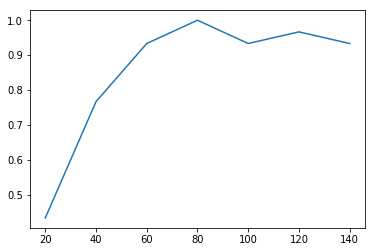

In [25]:
accs = []
for size in range(20, 150, 20):
    X_train, X_test, y_train, y_test = train_test_split(matr, articles['lg'], train_size=size, test_size=30)
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    pred = nb.predict(X_test)
    accs.append(accuracy_score(y_test, pred))

plt.plot(list(range(20, 150, 20)), accs)
plt.show()

Видимо, 20 слишком мало, а дальше как-то случайно. То есть в принципе уже с 40 статьями википедии можно построить приличный классификатор на триграммах. Примерно от 80 уже даже вполне хороший. Но всё зависит от random state, конечно.

/Users/user/myproject/venv/anaconda3/envs/maga/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


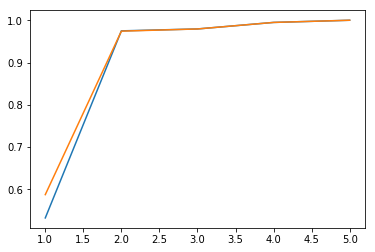

In [35]:
f1s = []
accs = []

for i in range(1, 6):
    vect = TfidfVectorizer(ngram_range=(i, i), analyzer='char', preprocessor=preproc)
    matr = vect.fit_transform(articles['text'])

    X_train, X_test, y_train, y_test = train_test_split(matr, articles['lg'])

    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    pred = nb.predict(X_test)
    f1s.append(f1_score(y_test, pred, average='weighted'))
    accs.append(accuracy_score(y_test, pred))


plt.plot(list(range(1, 6)), f1s)
plt.plot(list(range(1, 6)), accs)

plt.show()

В целом снова то же самое. Я специально подбирала языки с (почти) идентичными алфавитами, так что с униграммами результат 